In [2]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
# Enable FastF1 caching
fastf1.Cache.enable_cache("f1_cache")
pd.set_option('display.max_columns', None)


In [4]:
season = 2024

In [5]:
races = fastf1.get_event_schedule(season).loc[lambda df: df["EventFormat"]!="testing"]

In [6]:
races.head()

,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,Session2,Session2Date,Session2DateUtc,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
1,1,Bahrain,Sakhir,FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2024,2024-03-02,Bahrain Grand Prix,conventional,Practice 1,2024-02-29 14:30:00+03:00,2024-02-29 11:30:00,Practice 2,2024-02-29 18:00:00+03:00,2024-02-29 15:00:00,Practice 3,2024-03-01 15:30:00+03:00,2024-03-01 12:30:00,Qualifying,2024-03-01 19:00:00+03:00,2024-03-01 16:00:00,Race,2024-03-02 18:00:00+03:00,2024-03-02 15:00:00,True
2,2,Saudi Arabia,Jeddah,FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2024,2024-03-09,Saudi Arabian Grand Prix,conventional,Practice 1,2024-03-07 16:30:00+03:00,2024-03-07 13:30:00,Practice 2,2024-03-07 20:10:00+03:00,2024-03-07 17:10:00,Practice 3,2024-03-08 16:30:00+03:00,2024-03-08 13:30:00,Qualifying,2024-03-08 20:00:00+03:00,2024-03-08 17:00:00,Race,2024-03-09 20:00:00+03:00,2024-03-09 17:00:00,True
3,3,Australia,Melbourne,FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2024,2024-03-24,Australian Grand Prix,conventional,Practice 1,2024-03-22 12:30:00+11:00,2024-03-22 01:30:00,Practice 2,2024-03-22 16:00:00+11:00,2024-03-22 05:00:00,Practice 3,2024-03-23 12:30:00+11:00,2024-03-23 01:30:00,Qualifying,2024-03-23 16:00:00+11:00,2024-03-23 05:00:00,Race,2024-03-24 15:00:00+11:00,2024-03-24 04:00:00,True
4,4,Japan,Suzuka,FORMULA 1 MSC CRUISES JAPANESE GRAND PRIX 2024,2024-04-07,Japanese Grand Prix,conventional,Practice 1,2024-04-05 11:30:00+09:00,2024-04-05 02:30:00,Practice 2,2024-04-05 15:00:00+09:00,2024-04-05 06:00:00,Practice 3,2024-04-06 11:30:00+09:00,2024-04-06 02:30:00,Qualifying,2024-04-06 15:00:00+09:00,2024-04-06 06:00:00,Race,2024-04-07 14:00:00+09:00,2024-04-07 05:00:00,True
5,5,China,Shanghai,FORMULA 1 LENOVO CHINESE GRAND PRIX 2024,2024-04-21,Chinese Grand Prix,sprint_qualifying,Practice 1,2024-04-19 11:30:00+08:00,2024-04-19 03:30:00,Sprint Qualifying,2024-04-19 15:30:00+08:00,2024-04-19 07:30:00,Sprint,2024-04-20 11:00:00+08:00,2024-04-20 03:00:00,Qualifying,2024-04-20 15:00:00+08:00,2024-04-20 07:00:00,Race,2024-04-21 15:00:00+08:00,2024-04-21 07:00:00,True


In [ ]:
# generate a dataframe for each race consisting of [Race, Driver, FP3 lasp time, qualifying position, race position]
all_results = []
for race in races.iterrows():
#     print(race[1])
    # Load the race results
    race_session = fastf1.get_session(season, race[1]["RoundNumber"], "R")
    race_session.load()
    df = race_session.results.copy()
    df = df.assign(**{"RoundNumber": race[1]["RoundNumber"], "Country": race[1]["Country"], "EventName": race[1]["EventName"]})
    q_session = fastf1.get_session(season, race[1]["RoundNumber"], "Qualifying")
    q_session.load()
    df = pd.merge(df, q_session.results[["DriverNumber", "Position"]].rename(columns={"Position": "QualifyingPosition"}), how="left", on="DriverNumber")
    # Add FP3 best lap time
    try:
        fp3_session = fastf1.get_session(season, race[1]["RoundNumber"], "Practice 3")
    except ValueError:
        # Sprint weekend doesn't have FP3, is FP1 instead
        fp3_session = fastf1.get_session(season, race[1]["RoundNumber"], "Practice 1")
    fp3_session.load()
    fp3_laps = fp3_session.laps.copy()
    fp3_laps = fp3_laps[["DriverNumber", "LapTime"]].dropna()
    fastest_fp3_laps = fp3_laps[["DriverNumber", "LapTime"]].dropna().loc[fp3_laps.groupby("DriverNumber").LapTime.idxmin()].rename(columns={"LapTime":"FP3BestLapTime"})
    # Join Race results and FP3 datas
    df = pd.merge(df, fastest_fp3_laps, on="DriverNumber")
    all_results.append(df)

In [30]:
df = pd.concat(all_results)

In [31]:
df.to_parquet("2024_fp3_results.parquet")

In [32]:
df.head()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,RoundNumber,Country,EventName,QualifyingPosition,FP3BestLapTime
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,https://media.formula1.com/d_driver_fallback_i...,NED,1.0,1,1.0,NaT,NaT,NaT,0 days 01:31:44.742000,Finished,26.0,1,Bahrain,Bahrain Grand Prix,1.0,0 days 00:01:31.062000
1,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,https://media.formula1.com/d_driver_fallback_i...,MEX,2.0,2,5.0,NaT,NaT,NaT,0 days 00:00:22.457000,Finished,18.0,1,Bahrain,Bahrain Grand Prix,5.0,0 days 00:01:31.248000
2,55,C SAINZ,SAI,sainz,Ferrari,e8002d,ferrari,Carlos,Sainz,Carlos Sainz,https://media.formula1.com/d_driver_fallback_i...,ESP,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:25.110000,Finished,15.0,1,Bahrain,Bahrain Grand Prix,4.0,0 days 00:01:30.824000
3,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,https://media.formula1.com/d_driver_fallback_i...,MON,4.0,4,2.0,NaT,NaT,NaT,0 days 00:00:39.669000,Finished,12.0,1,Bahrain,Bahrain Grand Prix,2.0,0 days 00:01:31.094000
4,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,https://media.formula1.com/d_driver_fallback_i...,GBR,5.0,5,3.0,NaT,NaT,NaT,0 days 00:00:46.788000,Finished,10.0,1,Bahrain,Bahrain Grand Prix,3.0,0 days 00:01:31.190000


# Build features

### Add FP3 delta feature

In [33]:
# Compute fastest FP3 time per 

In [34]:
# Compute fastest FP3 time per race
best_fp3_times = df.groupby(["EventName", "RoundNumber"])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"}).reset_index()
df = pd.merge(df, best_fp3_times, how="left", on=["EventName", "RoundNumber"])

In [35]:
df["FP3Delta"] = df["FP3BestLapTime"] - df["FP3BestOverallLapTime"]
df["FP3DeltaFrac"] = df["FP3Delta"] / df["FP3BestLapTime"]

# Really simple model

### FP3 delta time as a predictor of race position

In [46]:
df.head(10)

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,RoundNumber,Country,EventName,QualifyingPosition,FP3BestLapTime,FP3BestOverallLapTime,FP3Delta,FP3DeltaFrac
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,https://media.formula1.com/d_driver_fallback_i...,NED,1.0,1,1.0,NaT,NaT,NaT,0 days 01:31:44.742000,Finished,26.0,1,Bahrain,Bahrain Grand Prix,1.0,0 days 00:01:31.062000,0 days 00:01:30.824000,0 days 00:00:00.238000,0.002614
1,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,https://media.formula1.com/d_driver_fallback_i...,MEX,2.0,2,5.0,NaT,NaT,NaT,0 days 00:00:22.457000,Finished,18.0,1,Bahrain,Bahrain Grand Prix,5.0,0 days 00:01:31.248000,0 days 00:01:30.824000,0 days 00:00:00.424000,0.004647
2,55,C SAINZ,SAI,sainz,Ferrari,e8002d,ferrari,Carlos,Sainz,Carlos Sainz,https://media.formula1.com/d_driver_fallback_i...,ESP,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:25.110000,Finished,15.0,1,Bahrain,Bahrain Grand Prix,4.0,0 days 00:01:30.824000,0 days 00:01:30.824000,0 days 00:00:00,0.000000
3,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,https://media.formula1.com/d_driver_fallback_i...,MON,4.0,4,2.0,NaT,NaT,NaT,0 days 00:00:39.669000,Finished,12.0,1,Bahrain,Bahrain Grand Prix,2.0,0 days 00:01:31.094000,0 days 00:01:30.824000,0 days 00:00:00.270000,0.002964
4,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,https://media.formula1.com/d_driver_fallback_i...,GBR,5.0,5,3.0,NaT,NaT,NaT,0 days 00:00:46.788000,Finished,10.0,1,Bahrain,Bahrain Grand Prix,3.0,0 days 00:01:31.190000,0 days 00:01:30.824000,0 days 00:00:00.366000,0.004014
5,4,L NORRIS,NOR,norris,McLaren,ff8000,mclaren,Lando,Norris,Lando Norris,https://media.formula1.com/d_driver_fallback_i...,GBR,6.0,6,7.0,NaT,NaT,NaT,0 days 00:00:48.458000,Finished,8.0,1,Bahrain,Bahrain Grand Prix,7.0,0 days 00:01:31.118000,0 days 00:01:30.824000,0 days 00:00:00.294000,0.003227
6,44,L HAMILTON,HAM,hamilton,Mercedes,27f4d2,mercedes,Lewis,Hamilton,Lewis Hamilton,https://media.formula1.com/d_driver_fallback_i...,GBR,7.0,7,9.0,NaT,NaT,NaT,0 days 00:00:50.324000,Finished,6.0,1,Bahrain,Bahrain Grand Prix,9.0,0 days 00:01:31.452000,0 days 00:01:30.824000,0 days 00:00:00.628000,0.006867
7,81,O PIASTRI,PIA,piastri,McLaren,ff8000,mclaren,Oscar,Piastri,Oscar Piastri,https://media.formula1.com/d_driver_fallback_i...,AUS,8.0,8,8.0,NaT,NaT,NaT,0 days 00:00:56.082000,Finished,4.0,1,Bahrain,Bahrain Grand Prix,8.0,0 days 00:01:31.210000,0 days 00:01:30.824000,0 days 00:00:00.386000,0.004232
8,14,F ALONSO,ALO,alonso,Aston Martin,229971,aston_martin,Fernando,Alonso,Fernando Alonso,https://media.formula1.com/d_driver_fallback_i...,ESP,9.0,9,6.0,NaT,NaT,NaT,0 days 00:01:14.887000,Finished,2.0,1,Bahrain,Bahrain Grand Prix,6.0,0 days 00:01:30.965000,0 days 00:01:30.824000,0 days 00:00:00.141000,0.001550
9,18,L STROLL,STR,stroll,Aston Martin,229971,aston_martin,Lance,Stroll,Lance Stroll,https://media.formula1.com/d_driver_fallback_i...,CAN,10.0,10,12.0,NaT,NaT,NaT,0 days 00:01:33.216000,Finished,1.0,1,Bahrain,Bahrain Grand Prix,12.0,0 days 00:01:31.396000,0 days 00:01:30.824000,0 days 00:00:00.572000,0.006258


In [37]:
X = df[["FP3DeltaFrac"]]
y = df["Position"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Import LinearRegression.
from sklearn.linear_model import LinearRegression


# Instantiate linear regression model.
model = LinearRegression()

In [40]:
# Fit the model to the training data.
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [41]:
import seaborn as sns

<Axes: xlabel='y', ylabel='y_pred'>

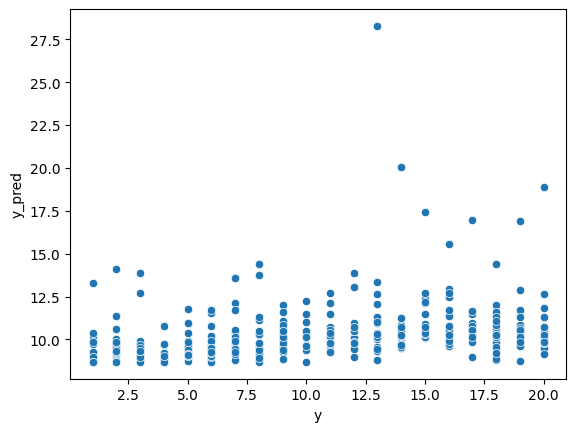

In [42]:
# In-sample results
y_pred = model.predict(X_train)
sns.scatterplot(pd.DataFrame.from_dict({"y": y_train, "y_pred": y_pred}), x="y", y="y_pred")

<Axes: xlabel='y', ylabel='y_pred'>

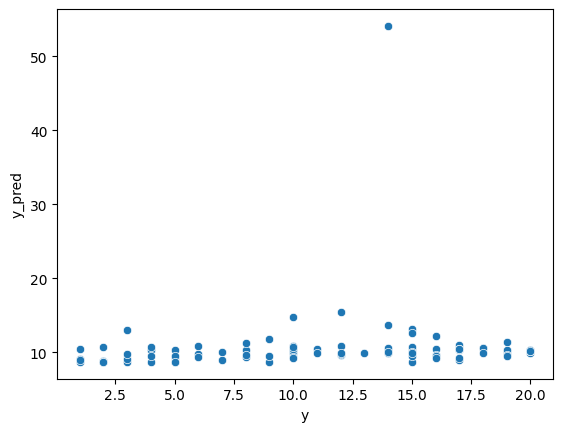

In [43]:
# Test results
y_pred = model.predict(X_test)
sns.scatterplot(pd.DataFrame.from_dict({"y": y_test, "y_pred": y_pred}), x="y", y="y_pred")